In [1]:
import pandas as pd
import sqlalchemy as sa

from src.settings import DATABASE_NAME

In [2]:
foot_to_cm = 30.48
inch_to_cm = 2.54
lb_to_kg = 0.453592


In [5]:
engine = sa.create_engine(f'sqlite:///{DATABASE_NAME}')

### Import Data

In [6]:
games = pd.read_sql_table('games', engine).drop_duplicates()
teams = pd.read_sql_table('team_info', engine).drop_duplicates()
player_info = pd.read_sql_table('player_info', engine).drop_duplicates()
game_players = pd.read_sql_table('game_players', engine).drop_duplicates()
scratches_game_stats = pd.read_sql_table(
    'scratches_game_stats', engine).drop_duplicates()
skater_game_stats = pd.read_sql_table(
    'skater_game_stats', engine).drop_duplicates()


### Wrangling Data

In [7]:
# Games
games['season_num'] = games['season'].str[:4].astype(int)

In [8]:
# flag scratches
scratches_game_stats['is_scratch'] = True
game_players_w_scratch = pd.merge(game_players, scratches_game_stats[['player_id', 'game_id', 'is_scratch']], on=['game_id', 'player_id'], how='left')
game_players_w_scratch.fillna(False, inplace=True)


In [9]:
game_players_details = pd.merge(
    games[['season_num', 'game_id', 'type']], 
    game_players_w_scratch[game_players_w_scratch['is_scratch']==False], 
    on='game_id')

In [10]:
total_player_game_stats = game_players_details[
    game_players_details['type'].isin(['R'])].groupby('player_id', as_index=False).agg({
        'game_id': 'nunique',
        'season_num': ['min', 'max', 'nunique']})
total_player_game_stats.columns = ['_'.join(col).strip()
                                   for col in total_player_game_stats.columns.values]
total_player_game_stats.rename(columns={
                               'player_id_': 'player_id',
                               'game_id': 'game_id_nunique', 
                               'season_num_min': 'first_season_played',
                               'season_num_max': 'last_season_played',
                               'season_num_nunique': 'number_seasons_played',
                               }, inplace=True)


In [11]:
# Player Info
player_info['birthYear'] = player_info['birthDate'].str[:4].astype(int)
player_info['height_cm'] = ((player_info['height'].str.
                             split('\'', expand=True)[1].str.
                             split('"', expand=True)[0].astype(float)*inch_to_cm) +
                            (player_info['height'].str.split(
                                '\'', expand=True)[0].astype(float)*foot_to_cm)
                            )
player_info['weight_kg'] = player_info['weight'] * lb_to_kg

player_info['BMI'] = player_info['weight_kg'] / \
    ((player_info['height_cm']/100)**2)

In [12]:
skater_game_stats_details = pd.merge(
    games[['season_num', 'game_id', 'type']],
    skater_game_stats,
    on='game_id')


In [16]:
def calculate_time_on_ice(df, col):

    split_vals = df[col].str.split(':', expand=True)

    split_vals.fillna(0, inplace=True)

    col = (split_vals[0].astype(int) * 60 +
           split_vals[1].astype(int))

    return col


In [21]:
# Skater game datatimeOnIce_seconds
skater_game_stats_details['timeOnIce_seconds'] = calculate_time_on_ice(skater_game_stats_details, 'timeOnIce')
skater_game_stats_details['evenTimeOnIce_seconds'] = calculate_time_on_ice(
    skater_game_stats_details, 'evenTimeOnIce')

skater_game_stats_details['shortHandedTimeOnIce_seconds'] = calculate_time_on_ice(
    skater_game_stats_details, 'shortHandedTimeOnIce')

skater_game_stats_details['powerPlayTimeOnIce_seconds'] = calculate_time_on_ice(
    skater_game_stats_details, 'powerPlayTimeOnIce')


In [33]:
games.columns

Index(['game_id', 'season', 'type', 'date_time_GMT', 'away_team_id',
       'home_team_id', 'away_goals', 'home_goals', 'venue', 'outcome',
       'season_num'],
      dtype='object')

<AxesSubplot:xlabel='season_num'>

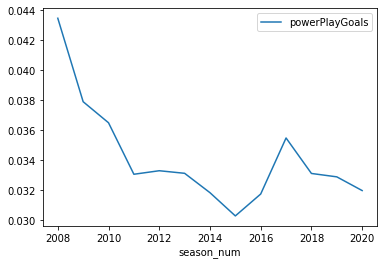

In [32]:
skater_game_stats_details[
    skater_game_stats_details['season_num']>2007
].groupby(['season_num']).agg({'powerPlayGoals': 'mean'}).plot()


In [ ]:
player_stats = pd.merge(player_info, total_player_game_stats, on='player_id')

### Select Games > 2008

In [ ]:
games_recent = games[games['season_num']>=2008]
game_players_recent = game_players_w_scratch[
    game_players['game_id'].isin(games_recent['game_id'])
    ]
player_stats_recent = player_stats[player_stats['player_id'].isin(
    game_players_recent['player_id'])]


<AxesSubplot:xlabel='birthYear'>

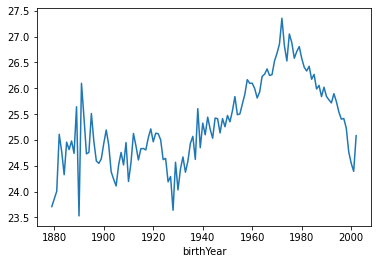

In [ ]:
player_info.groupby('birthYear')['BMI'].mean().plot()

<AxesSubplot:xlabel='birthYear'>

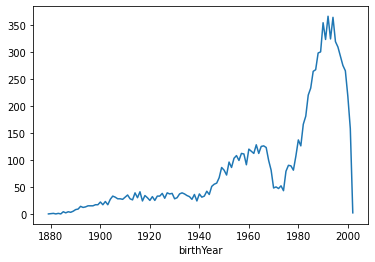

In [ ]:
player_info.groupby('birthYear')['player_id'].count().plot()

<AxesSubplot:xlabel='birthYear'>

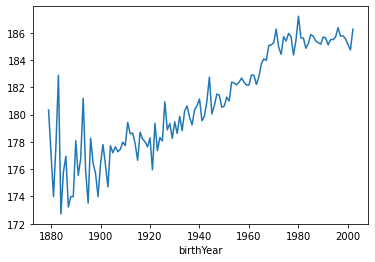

In [ ]:
player_info.groupby('birthYear')['height_cm'].mean().plot()


<AxesSubplot:xlabel='birthYear'>

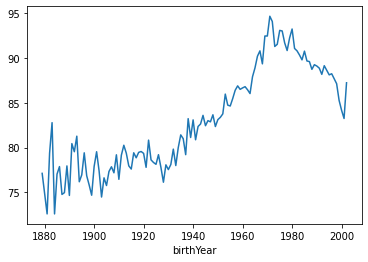

In [ ]:
player_info.groupby('birthYear')['weight_kg'].mean().plot()


In [ ]:
teams_games = pd.merge(
    games, teams, left_on='home_team_id', right_on='team_id')


In [ ]:
teams_games[teams_games['teamName'].str.contains('Leafs')]


,game_id,season,type,date_time_GMT,away_team_id,home_team_id,away_goals,home_goals,venue_x,outcome,...,teamName,locationName,firstYearOfPlay,division,conference,franchise,franchise_id,shortName,officialSiteUrl,active
7417,2005020582,20052006,R,2006-01-03T00:30:00Z,5,10,2,3,Air Canada Centre,home win OT/Shootout4,...,Maple Leafs,Toronto,1917,Atlantic,Eastern,Maple Leafs,5.0,Toronto,http://www.mapleleafs.com/,True
7418,2005020659,20052006,R,2006-01-15T00:00:00Z,27,10,4,3,Air Canada Centre,away win REG3,...,Maple Leafs,Toronto,1917,Atlantic,Eastern,Maple Leafs,5.0,Toronto,http://www.mapleleafs.com/,True
7419,2005020741,20052006,R,2006-01-27T00:30:00Z,7,10,8,4,Air Canada Centre,away win REG3,...,Maple Leafs,Toronto,1917,Atlantic,Eastern,Maple Leafs,5.0,Toronto,http://www.mapleleafs.com/,True
7420,2005020757,20052006,R,2006-01-29T00:00:00Z,8,10,4,3,Air Canada Centre,away win OT/Shootout4,...,Maple Leafs,Toronto,1917,Atlantic,Eastern,Maple Leafs,5.0,Toronto,http://www.mapleleafs.com/,True
7421,2005020803,20052006,R,2006-02-05T00:00:00Z,1,10,2,4,Air Canada Centre,home win REG3,...,Maple Leafs,Toronto,1917,Atlantic,Eastern,Maple Leafs,5.0,Toronto,http://www.mapleleafs.com/,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8072,2020020438,20202021,R,2021-03-14T00:00:00Z,52,10,5,2,Scotiabank Arena,away win REG3,...,Maple Leafs,Toronto,1917,Atlantic,Eastern,Maple Leafs,5.0,Toronto,http://www.mapleleafs.com/,True
8073,2020020480,20202021,R,2021-03-19T23:00:00Z,20,10,4,3,Scotiabank Arena,away win REG3,...,Maple Leafs,Toronto,1917,Atlantic,Eastern,Maple Leafs,5.0,Toronto,http://www.mapleleafs.com/,True
8074,2020020490,20202021,R,2021-03-20T23:00:00Z,20,10,0,2,Scotiabank Arena,home win REG3,...,Maple Leafs,Toronto,1917,Atlantic,Eastern,Maple Leafs,5.0,Toronto,http://www.mapleleafs.com/,True
8075,2020020536,20202021,R,2021-03-27T23:00:00Z,22,10,3,4,Scotiabank Arena,home win OT/Shootout4,...,Maple Leafs,Toronto,1917,Atlantic,Eastern,Maple Leafs,5.0,Toronto,http://www.mapleleafs.com/,True
